In [1]:
# disable Jedi for better autocomplete
%config Completer.use_jedi = False

# you can make it permanent by adding the following line to your Jupyter config file
# ~/.jupyter/jupyter_notebook_config.py
# c.Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import libraries 
import pickle

import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random

## Traffic Sign Detection

Traffic sign detection using German traffic sign dataset is a multi-class classification problem that contains more than 40 classes and more than 50000 images. The physical traffic sign instances are unique within the dataset, and each real-world traffic sign only occur once.

In [4]:
with open("./traffic-signs-data/train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("./traffic-signs-data/valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("./traffic-signs-data/test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [5]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
X_train.shape

(34799, 32, 32, 3)

In [7]:
y_train.shape

(34799,)

## Image exploration

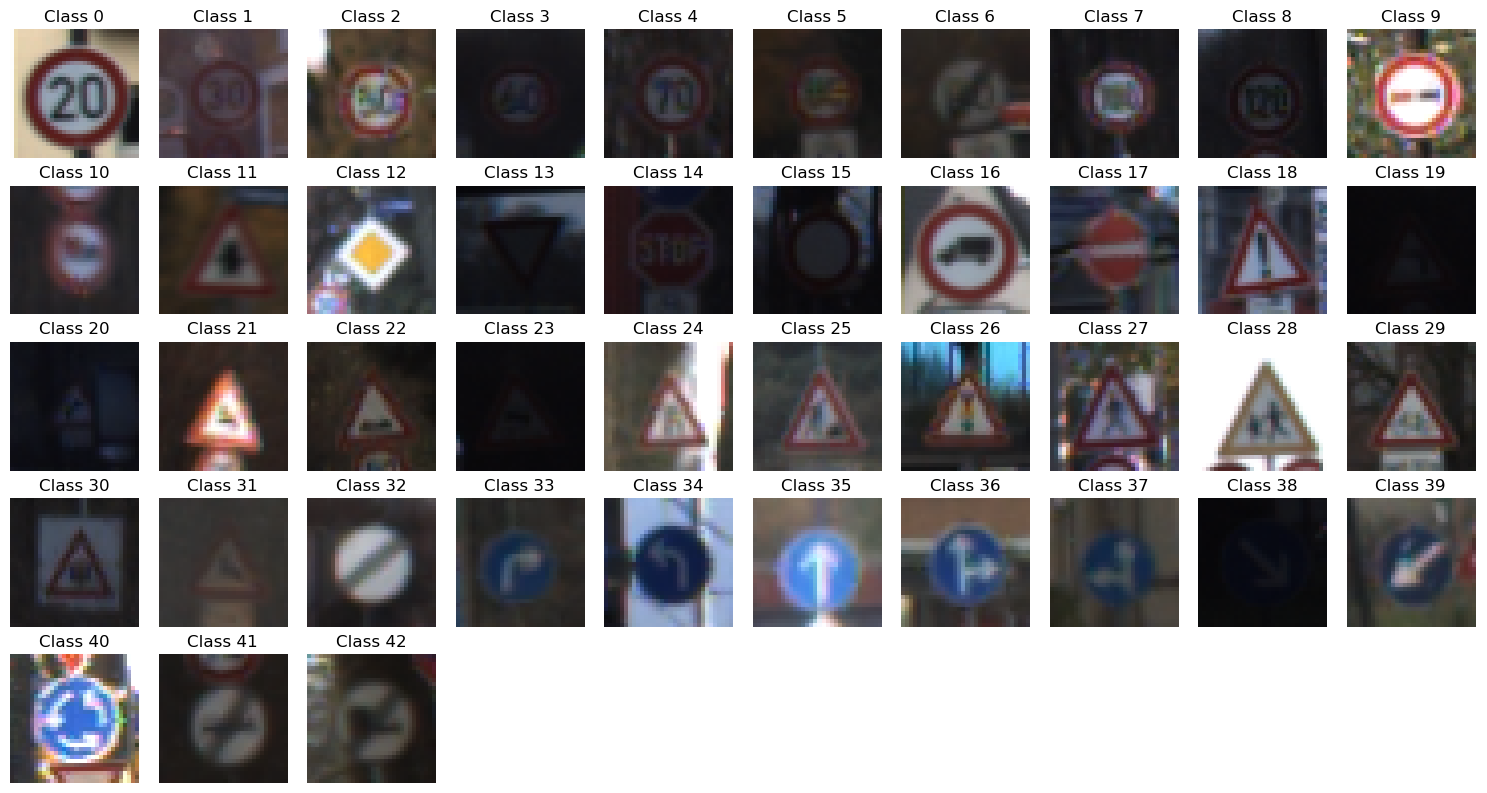

In [8]:
# Assuming X_train contains images and y_train contains corresponding labels
unique_classes = np.unique(y_train)  # Get unique class labels
samples_per_class = {}  # Dictionary to store one sample per class

# Collect one image per class (sorted by class label)
for label in sorted(unique_classes):  # Ensure labels are in order
    index = np.where(y_train == label)[0][0]  # Get first occurrence of the class
    samples_per_class[label] = X_train[index]  # Store the image

# Plot images
num_classes = len(samples_per_class)
rows, cols = (num_classes // 10) + 1, min(10, num_classes)  # Adjust grid size

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, (label, img) in enumerate(sorted(samples_per_class.items())):
    axes[i].imshow(img)
    axes[i].set_title(f"Class {label}")
    axes[i].axis("off")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Data preparation

In [9]:
## Shuffle the dataset 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [10]:
# convert to grayscale
X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_test_gray  = np.sum(X_test/3, axis=3, keepdims=True)
X_validation_gray  = np.sum(X_validation/3, axis=3, keepdims=True) 

In [11]:
# normalize
X_train_gray_norm = (X_train_gray - 128)/128 
X_test_gray_norm = (X_test_gray - 128)/128
X_validation_gray_norm = (X_validation_gray - 128)/128

In [12]:
X_train_gray.shape

(34799, 32, 32, 1)

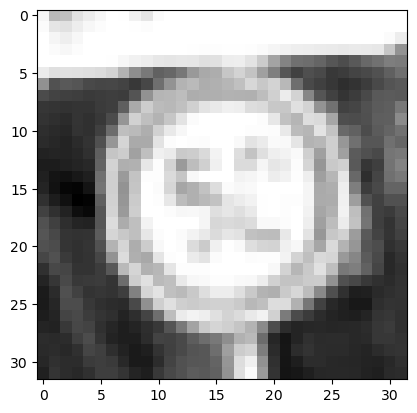

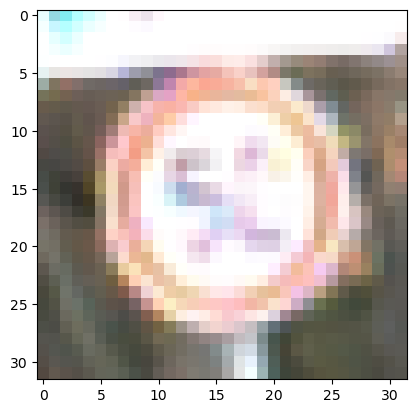

In [13]:
i = 610
plt.imshow(X_train_gray[i].squeeze(), cmap='gray')
plt.figure()
plt.imshow(X_train[i])

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from subprocess import check_output
from sklearn.model_selection import train_test_split

In [15]:
image_shape = X_train_gray[i].shape

In [16]:
image_shape

(32, 32, 1)

In [17]:
cnn_model = tf.keras.Sequential()

# output shape: 32x32x1
cnn_model.add(tf.keras.layers.Input(shape=image_shape)) # input shape is image_shape

# output shape: 30 x 30 x 32, #learnable_parameters (single channel image): 3*3*1*32 + 32 = 320 
cnn_model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# output shape: 28 x 28 x 64, #learnable_paremeters: 3*3*32*64 + 64 = 18496
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation='relu'))
# output shape: 14x14x64, #learnable_paremeters: 0 
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))
# output shape: 14x14x64, #learnable_paremeters: 0
cnn_model.add(tf.keras.layers.Dropout(0.25))
# output shape: 12544, #learnable_paremeters: 0
cnn_model.add(tf.keras.layers.Flatten())
# output shape: 128, #learnable_parameters: 12544 *  128 + 128 = 1605760
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
# output shape: 128, #learnable_paremeters: 0
cnn_model.add(tf.keras.layers.Dropout(0.5))

# Sigmoid is used for binary classification (only two classes, e.g., "stop sign" vs. "not stop sign").
# If you were doing multi-label classification (where an image can belong to multiple classes at the same time), you could use sigmoid on each output neuron; i.e. activation = 'sigmoid'.
# But, here we need to use softmax: 
# - The dataset involves multi-class classification (each image belongs to exactly one class out of many).
# - Softmax outputs a probability distribution over all classes, making it suitable for multi-class classification.
# - The model will predict the class with the highest probability.
# output shape: 43, #learnable_paremeters: 128 * 43 + 43 = 5547
cnn_model.add(tf.keras.layers.Dense(43, activation = 'softmax'))

In [18]:
# we are using loss = 'sparse_categorical_crossentropy' because we have 43 different classes. We are using Adam as an optimizer as it is appropriate for the sparse gradient problems; 
# its parameters require little bit tuning as they are computationally efficient and invariant to any diagonal rescaling of gradients.
cnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), metrics = ['accuracy'])

In [19]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [20]:
history = cnn_model.fit(X_train_gray_norm,
                        y_train,
                        batch_size=32,
                        epochs=60,
                        verbose=1,
                        validation_data = (X_validation_gray_norm, y_validation))

Train on 34799 samples, validate on 4410 samples
Epoch 1/60
34799/34799 [==============================] - 10s 276us/sample - loss: 1.1253 - accuracy: 0.6856 - val_loss: 0.3103 - val_accuracy: 0.9150
Epoch 2/60
34799/34799 [==============================] - 6s 179us/sample - loss: 0.3376 - accuracy: 0.8986 - val_loss: 0.1928 - val_accuracy: 0.9442
Epoch 3/60
34799/34799 [==============================] - 6s 180us/sample - loss: 0.2281 - accuracy: 0.9288 - val_loss: 0.1653 - val_accuracy: 0.9508
Epoch 4/60
34799/34799 [==============================] - 6s 179us/sample - loss: 0.1718 - accuracy: 0.9449 - val_loss: 0.1513 - val_accuracy: 0.9558
Epoch 5/60
34799/34799 [==============================] - 6s 180us/sample - loss: 0.1422 - accuracy: 0.9543 - val_loss: 0.1378 - val_accuracy: 0.9594
Epoch 6/60
34799/34799 [==============================] - 6s 180us/sample - loss: 0.1163 - accuracy: 0.9619 - val_loss: 0.1149 - val_accuracy: 0.9673
Epoch 7/60
34799/34799 [==========================

In [21]:
score = cnn_model.evaluate(X_test_gray_norm, y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2302
Test Accuracy : 0.9760


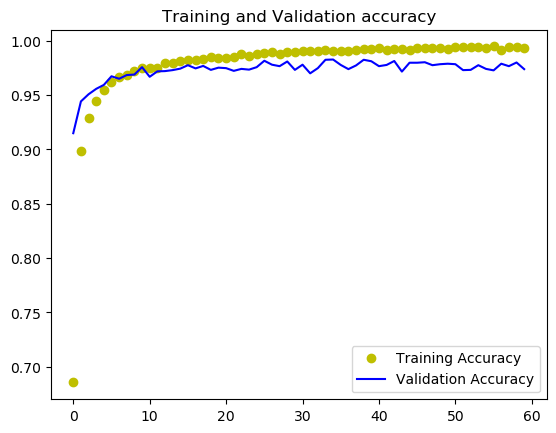

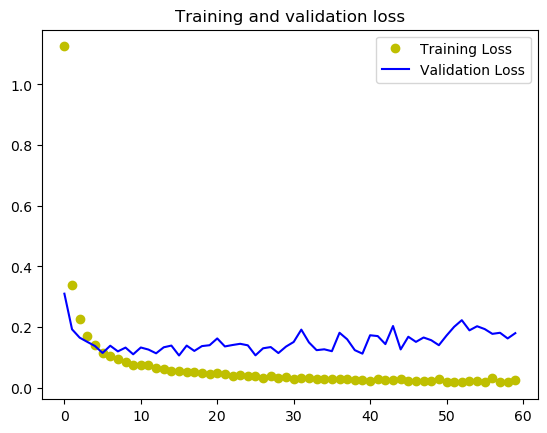

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'yo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'yo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

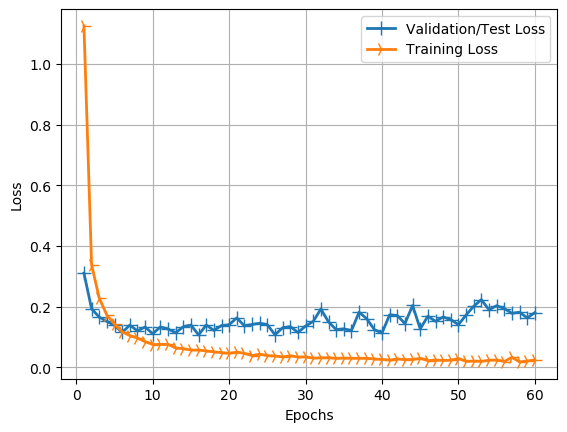

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+ 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label= 'Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker= '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

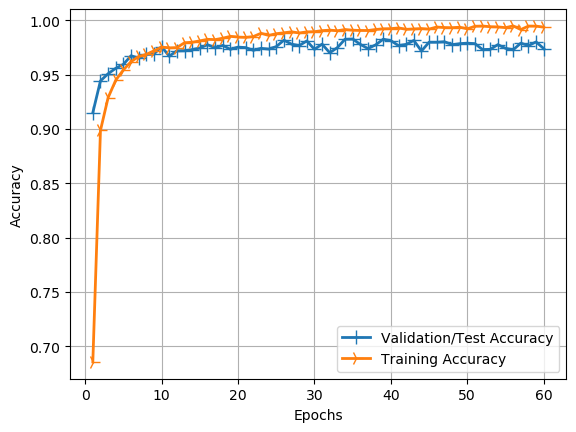

In [24]:
import matplotlib.pyplot as plt

history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values)+ 1)
line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label= 'Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker= '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
cnn_model.save("traffic_sign_model", save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: traffic_sign_model\assets


In [26]:
from keras.models import load_model
loaded_model = tf.keras.models.load_model('traffic_sign_model')

Using TensorFlow backend.


In [27]:
from tensorflow.keras.utils import plot_model
%matplotlib inline

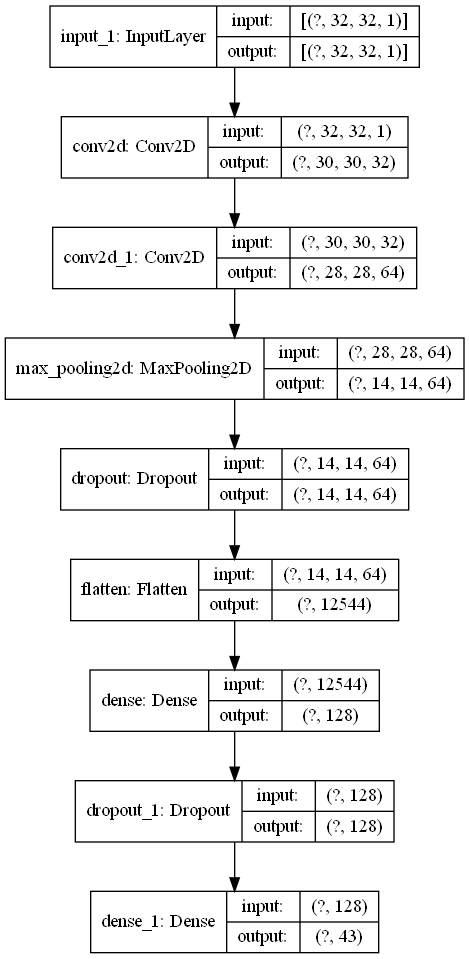

In [28]:
plot_model(cnn_model, to_file='model.png', show_shapes=True, show_layer_names=True)

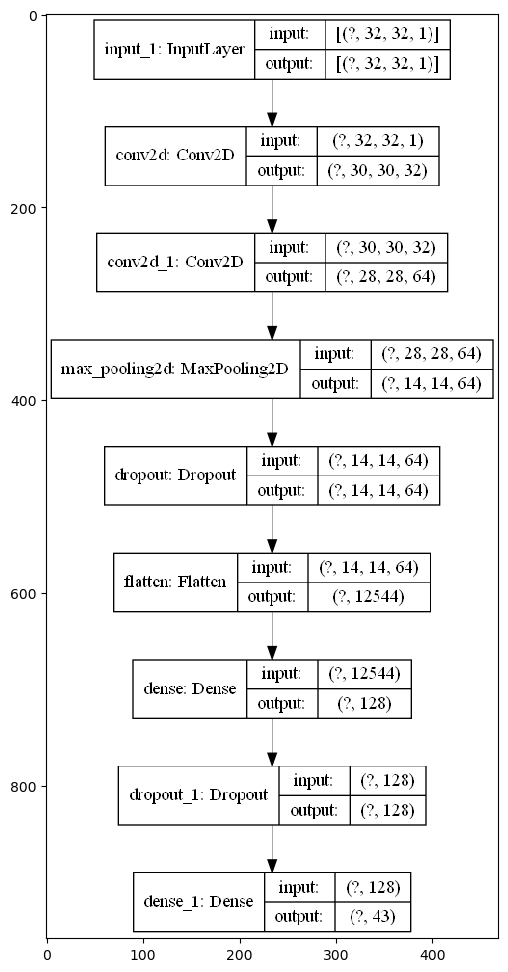

In [29]:
#Reading the model architecture image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("model.png")
plt.figure(figsize=(24, 12))  # Width=24 inches, Height=12 inches
plt.imshow(img)
plt.show()

## Confusion matrix

In [30]:
#get the predictions for the test data
predicted_classes = cnn_model.predict_classes(X_test_gray_norm)

y_pred = predicted_classes

#get the indices to be plotted
y_true = y_test

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted_classes)
cm

array([[ 58,   0,   0, ...,   0,   0,   0],
       [  0, 711,   1, ...,   0,   0,   0],
       [  0,   1, 747, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  81,   0,   0],
       [  0,   0,   0, ...,   0,  45,   0],
       [  0,   0,   0, ...,   1,  11,  75]], dtype=int64)

## More advanced confusion matrix

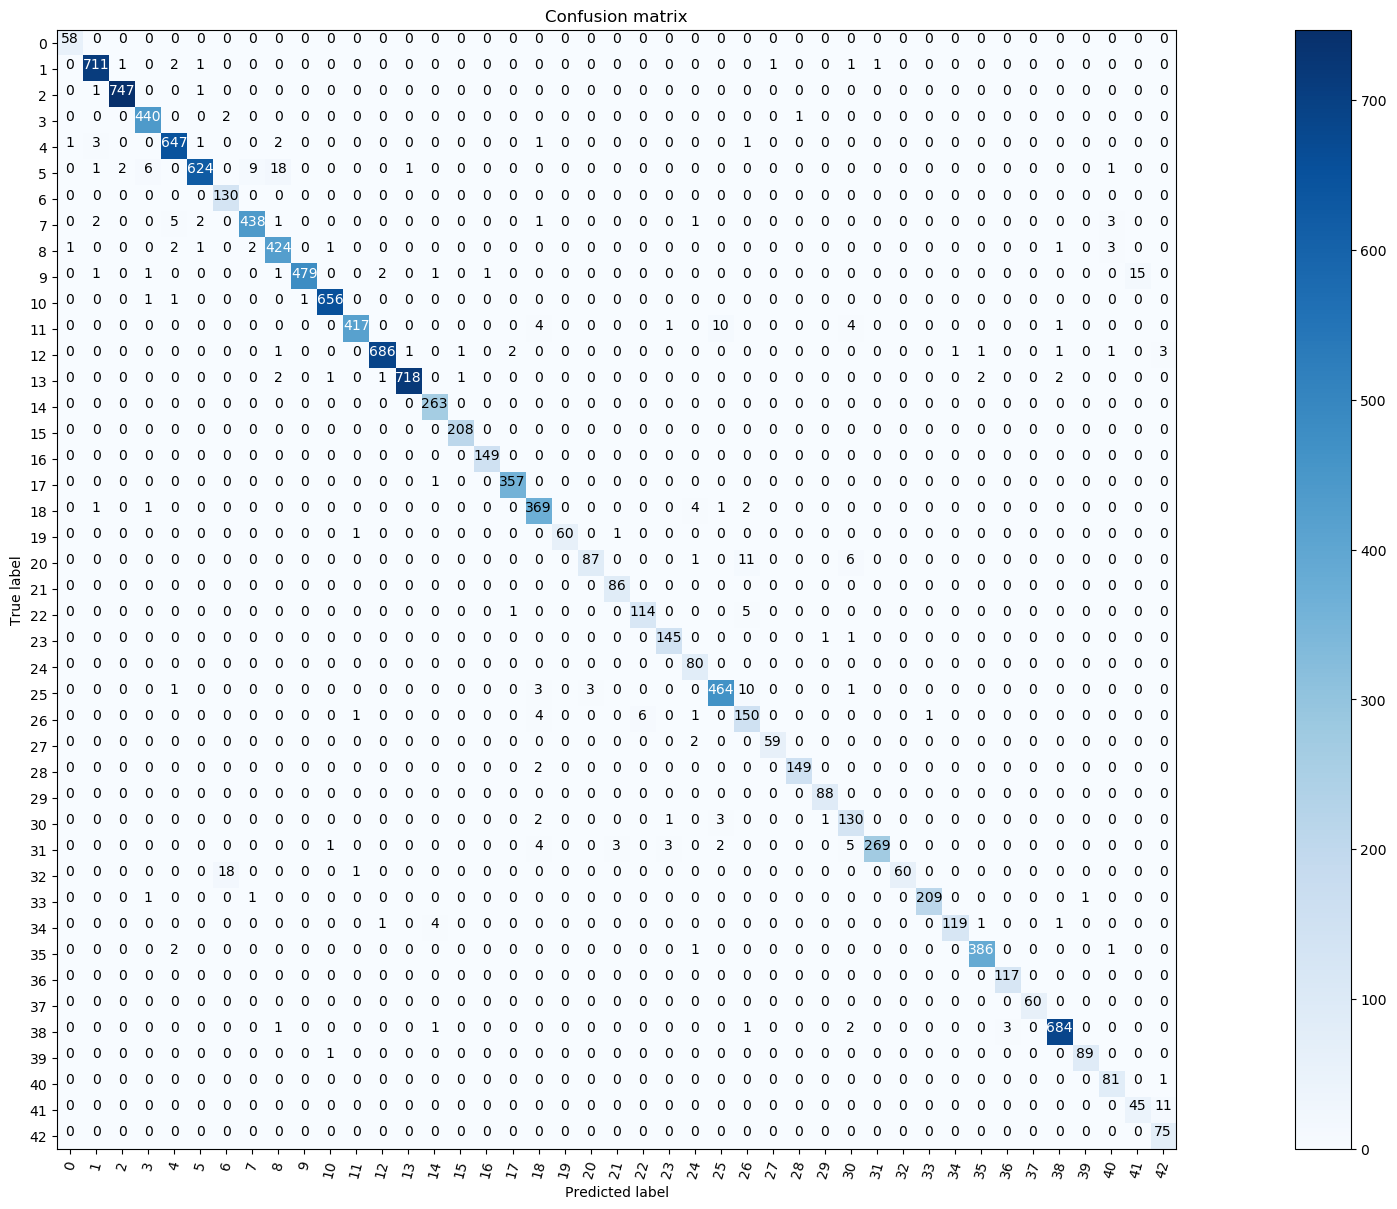

In [31]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=75) 
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = range(43)
cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(24, 12))  # Width=24 inches, Height=12 inches
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

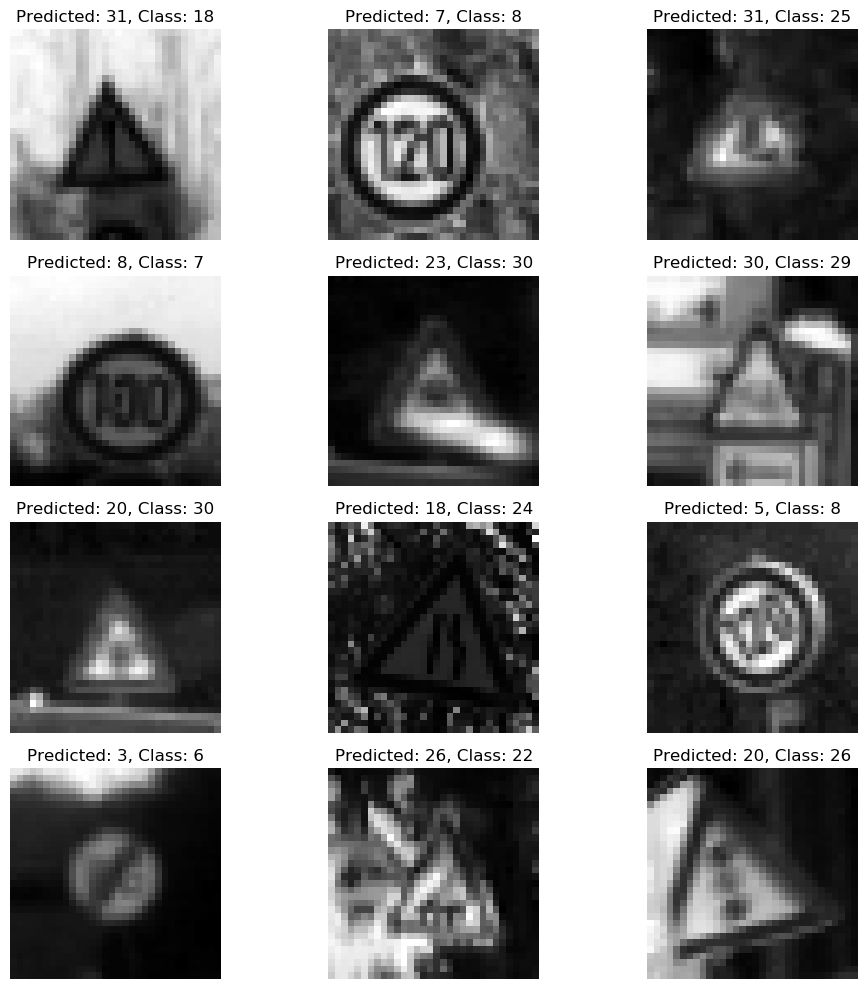

In [32]:
incorrect_indices = np.where(predicted_classes != y_true)[0]  # Find incorrect predictions

plt.figure(figsize=(10, 10))  # Adjust figure size
for i in range(min(12, len(incorrect_indices))):  # Show up to 12 images
    idx = incorrect_indices[i]  # Get index of incorrect prediction
    plt.subplot(4, 3, i + 1)
    plt.imshow(X_test_gray_norm[idx].squeeze(), cmap='gray', interpolation='none')
    plt.title(f"Predicted: {predicted_classes[idx]}, Class: {y_true[idx]}")
    plt.axis("off")  # Hide axes for better visualization

plt.tight_layout()
plt.show()

In [33]:
#Printing the classification report
from sklearn.metrics import classification_report
predictions = cnn_model.predict_classes(X_test_gray )
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92        60
           1       0.80      0.97      0.87       720
           2       0.53      1.00      0.69       750
           3       0.52      0.48      0.49       450
           4       0.91      0.90      0.90       660
           5       0.84      0.61      0.71       630
           6       1.00      0.25      0.40       150
           7       0.99      0.71      0.83       450
           8       0.88      0.82      0.85       450
           9       0.88      0.92      0.90       480
          10       0.98      0.80      0.88       660
          11       0.83      0.85      0.84       420
          12       0.88      0.98      0.93       690
          13       0.82      1.00      0.90       720
          14       1.00      0.86      0.92       270
          15       0.32      0.14      0.20       210
          16       1.00      0.67      0.80       150
          17       0.97    